In [1]:
import gym
from gym import spaces
import numpy as np
import tensorflow as tf

In [2]:
from stable_baselines3.common.env_checker import check_env

In [3]:
# on met le bateau sur notre matrice
def set_ship(ship, ships, board, ship_locs):

    grid_size = board.shape[0]
    
    done = False
    while not done:
        init_pos_i = np.random.randint(0, grid_size)
        init_pos_j = np.random.randint(0, grid_size)
                    
        move_j = grid_size - init_pos_j - ships[ship]
        if move_j > 0:
            move_j = 1
        else:
            move_j = -1
        move_i = grid_size - init_pos_i - ships[ship]
        if move_i > 0:
            move_i = 1
        else:
            move_i = -1
        # verticale ou horizontale
        choice_hv = np.random.choice(['h', 'v']) # horizontale, verticale
        if choice_hv == 'h': #horizontal
            j = [(init_pos_j + move_j*jj) for jj in range(ships[ship])]
            i = [init_pos_i for ii in range(ships[ship])]
            pos = set(zip(i,j))     
            if all([board[i,j]==0 for (i,j) in pos]):
                done = True
        elif choice_hv == 'v':
            i = [(init_pos_i + move_i*ii) for ii in range(ships[ship])]
            j = [init_pos_j for jj in range(ships[ship])]
            pos = set(zip(i,j))        
            #check if empty board in this direction
            if all([board[i,j]==0 for (i,j) in pos]):
                done = True
    # placement des bateaux
    for (i,j) in pos:
        board[i,j] = 1
        ship_locs[ship].append((i,j))
    
    return board, ship_locs

def board_rendering(grid_size, board):
    for i in range(grid_size):
        print("-"*(4*grid_size+2))
        for j in range(grid_size):
            current_state_value = board[i,j]
            current_state = ('S' if current_state_value==1 else ' ')
            print(" | ", end="")
            print(current_state, end='')
        print(' |')
    print("-"*(4*grid_size+2))

In [4]:
class BattleshipEnv(gym.Env):

    
    metadata = {'render.modes': ['human']} 


    def __init__(self, enemy_board, ship_locs, grid_size, ships):
        
        super(BattleshipEnv, self).__init__()
        
        # bateau
        self.ships = ships
        
        # grille
        self.grid_size = grid_size 
        # on setup la grille (pas découvert, touché, raté)
        self.cell = {'E': 0, 'X': 1, 'O': -1} 
        # grille, actions, récompenses
        self.board = self.cell['E']*np.ones((self.grid_size, self.grid_size), dtype='int')
        self.is_enemy_set = False
        self.enemy_board = enemy_board
        self.ship_locs = ship_locs
        if self.enemy_board is None:
            self.enemy_board = 0*np.ones((self.grid_size, self.grid_size), dtype='int')
            for ship in self.ships:
                self.ship_locs[ship] = []
                self.enemy_board, self.ship_locs = set_ship(ship, self.ships, self.enemy_board, self.ship_locs)
            self.is_enemy_set = True
        self.rdisc = 0
        self.legal_actions = [] # les bons move, on l'utilise après dans les récompenses
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                self.legal_actions.append((i,j))

        self.action_space = spaces.Discrete(self.grid_size * self.grid_size)
        self.observation_space = spaces.Box(low=-1, high=1,shape=(self.grid_size, self.grid_size), 
                                            dtype=int)

    def step(self, action):
                        
        state = self.board.copy()        
        empty_cnts_pre, hit_cnts_pre, miss_cnts_pre = self.board_config(state)
        i, j = np.unravel_index(action, (self.grid_size,self.grid_size))

        
        # perd 1points à chaque actions le poussant à jouer vite et de manière efficiente
        reward = -1
        # punition si hors jeu
        if (i,j) not in self.legal_actions:
            reward -= 2*self.grid_size
            action_idx = np.random.randint(0,len(self.legal_actions))
            
            i,j = self.legal_actions[action_idx]                
            action = np.ravel_multi_index((i,j), (self.grid_size,self.grid_size))
        

        self.set_state((i,j))
        self.set_legal_actions((i,j))

        next_state = self.board
               
        empty_cnts_post, hit_cnts_post, miss_cnts_post = self.board_config(next_state)

        # fin de partie
        done = bool(hit_cnts_post == sum(self.ships.values()))
                    
        # récompense si il hit
        if hit_cnts_post-hit_cnts_pre==1: 
           # r_discount = 1
            rp = (54 if done else self.grid_size)
            reward += rp + 18 #*r_discount

                    
        reward = float(reward)

        info = {}

        return next_state, reward, done, info


    
    def reset(self):

        self.board = self.cell['E']*np.ones((self.grid_size, self.grid_size), dtype='int')
        
        self.legal_actions = [] 
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                self.legal_actions.append((i,j))

        if self.is_enemy_set:
            self.enemy_board = 0*np.ones((self.grid_size, self.grid_size), dtype='int')
            self.ship_locs = {}
            for ship in self.ships:
                self.ship_locs[ship] = []
                self.enemy_board, self.ship_locs = set_ship(ship, self.ships, self.enemy_board, self.ship_locs)

        self.rdisc = 0

        return self.board
    

    def render(self, mode='human'):
        for i in range(self.grid_size):
            print("-"*(4*self.grid_size+2))
            for j in range(self.grid_size):
                current_state_value = self.board[i,j]
                current_state = list(self.cell.keys())[list(self.cell.values()).index(current_state_value)]
                current_state = (current_state if current_state!='E' else ' ')
                print(" | ", end="")
                print(current_state, end='')
            print(' |')
        print("-"*(4*self.grid_size+2))
        

    
    def board_config(self, state):
        uni_states, uni_cnts = np.unique(state.ravel(), return_counts=True)
        empty_cnts = uni_cnts[uni_states==self.cell['E']]
        hit_cnts = uni_cnts[uni_states==self.cell['X']]
        miss_cnts = uni_cnts[uni_states==self.cell['O']]
        if len(empty_cnts)==0:
            empty_cnts = 0
        else:
            empty_cnts = empty_cnts[0]
        if len(hit_cnts)==0:
            hit_cnts = 0
        else:
            hit_cnts = hit_cnts[0]
        if len(miss_cnts)==0:
            miss_cnts = 0
        else:
            miss_cnts = miss_cnts[0]
        
        return empty_cnts, hit_cnts, miss_cnts

    def set_state(self, action):
        i , j = action
        if self.enemy_board[i,j]==1:
            self.board[i,j]=self.cell['X']
        else:
            self.board[i,j]=self.cell['O']

    def set_legal_actions(self, action):
        if action in self.legal_actions:
            self.legal_actions.remove(action)
            

In [5]:
# grille de 6x6 avec bateau de 3x1

ships = {}
ships['bateau'] = 3

grid_size = 6

enemy_board = 0*np.ones((grid_size, grid_size), dtype='int')
enemy_board[0,1] = 1
enemy_board[1,1] = 1
enemy_board[2,1] = 1
ship_locs = {}
ship_locs['bateau'] = [(0,1),(1,1),(2,1)]
env = BattleshipEnv(enemy_board=enemy_board, ship_locs=ship_locs, grid_size=grid_size, ships=ships)

check_env(env, warn=True)
# msg d'erreur pour dire que notre matrice est trop grande, à ignorer

C:\Users\Claude\anaconda3\lib\site-packages\stable_baselines3\common\env_checker.py:130: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


In [6]:
env.enemy_board, env.ship_locs

(array([[0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]),
 {'bateau': [(0, 1), (1, 1), (2, 1)]})

In [7]:
# on test notre bataille

ships = {}
ships['bateau'] = 3

grid_size=6
env = BattleshipEnv(enemy_board=None, ship_locs={}, grid_size=grid_size, ships=ships)

for ep in range(2):
    print('Episode', ep)
    obs = env.reset()

    done = False
    t = 0
    while not done:
        action = env.action_space.sample()
        i, j = np.unravel_index(action, (grid_size,grid_size))    
        print("Action {}".format(t + 1), i, j)
        obs, reward, done, _ = env.step(action)
        print('obs=', obs, 'reward=', reward, 'done=', done)
        env.render()
        t += 1
        if done:
            print("Goal reached!", "reward=", reward)

# test où il joue tout seul et les récompenses que ça donne. voir dossier avec le tableau des récompenses pour comprendre ce qu'il fait.
# il faut beaucoup scroller :)

Episode 0
Action 1 5 5
obs= [[ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0 -1]] reward= -1.0 done= False
--------------------------
 |   |   |   |   |   |   |
--------------------------
 |   |   |   |   |   |   |
--------------------------
 |   |   |   |   |   |   |
--------------------------
 |   |   |   |   |   |   |
--------------------------
 |   |   |   |   |   |   |
--------------------------
 |   |   |   |   |   | O |
--------------------------
Action 2 5 1
obs= [[ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0 -1  0  0  0 -1]] reward= -1.0 done= False
--------------------------
 |   |   |   |   |   |   |
--------------------------
 |   |   |   |   |   |   |
--------------------------
 |   |   |   |   |   |   |
--------------------------
 |   |   |   |   |   |   |
--------------------------
 |   |   |   |   |   |   |
--------------------------
 |

In [8]:
import matplotlib.pyplot as plt

In [9]:
from stable_baselines3 import A2C, DQN

In [10]:
from sb3_contrib import TRPO

In [11]:
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results

In [13]:
from stable_baselines.bench import Monitor

In [14]:
from stable_baselines.common.vec_env import DummyVecEnv

In [15]:
import os

In [16]:
from stable_baselines3.common.callbacks import BaseCallback

In [17]:
from stable_baselines3.common.env_util import make_vec_env

In [18]:
def callback(_locals, _globals):

    global n_steps, best_mean_reward
    if (n_steps + 1) % step_interval == 0:
        x, y = ts2xy(load_results(log_dir), 'timesteps')
        if len(x) > 0:
            mean_reward = np.mean(y[-episode_interval:]) 
            mean_moves = np.mean(np.diff(x[-episode_interval:])) 
            print(x[-1], 'timesteps') 
            print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f} - Last mean moves per episode: {:.2f}".format(best_mean_reward, 
                                                                                           mean_reward, mean_moves))

            if mean_reward > best_mean_reward:
                best_mean_reward = mean_reward
                print("Saving new best model")
                _locals['self'].save(log_dir + 'best_model.pkl')
    n_steps += 1
    return True

In [19]:
# on lui dit de garder les meilleures récompenses pour qu'il l'applique
class SaveOnBestTrainingRewardCallback(BaseCallback):

    def __init__(self, check_freq: int, episode_interval: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.episode_interval = episode_interval
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model.pkl')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                mean_reward = np.mean(y[-self.episode_interval:]) 
                mean_moves = np.mean(np.diff(x[-self.episode_interval:])) 
                if self.verbose > 0:
                    print(x[-1], 'timesteps') 
                    print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f} - Last mean moves per episode: {:.2f}".format(self.best_mean_reward, 
                                                                                                   mean_reward, mean_moves))

                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    if self.verbose > 0:
                        print("Saving new best model")
                    self.model.save(self.save_path)

        return True

In [20]:
def moving_average(values, window):

    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, window = 100, title='Learning Curve'):
    
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=window)
    y_moves = moving_average(np.diff(x), window = window) 
    x = x[len(x) - len(y):]
    x_moves = x[len(x) - len(y_moves):]

    title = 'Smoothed Learning Curve of Rewards (every ' + str(window) +' steps)'
    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title)
    plt.show()

    title = 'Smoothed Learning Curve of Moves (every ' + str(window) +' steps)'
    fig = plt.figure(title)
    plt.plot(x_moves, y_moves)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Moves')
    plt.title(title)
    plt.show()

In [22]:
# on train notre pc. J'ai recall la grille et le bateau si je veux modifier mes paramètres. plus facile.
ships = {}
ships['bateau'] = 3

grid_size = 6
best_mean_reward, n_steps, step_interval, episode_interval = -np.inf, 0, 10000, 10000

# on call le jeu
env = BattleshipEnv(enemy_board=None, ship_locs={}, grid_size=grid_size, ships=ships)


log_dir = "./gym/"
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, filename=log_dir, allow_early_resets=True)


# on train avec a2c via stable_baseline3
GrosZbi = TRPO('MlpPolicy', env, verbose=0)
GrosZbi.learn(total_timesteps=15000000)

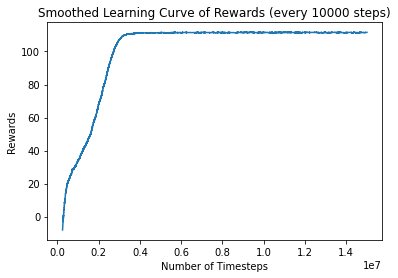

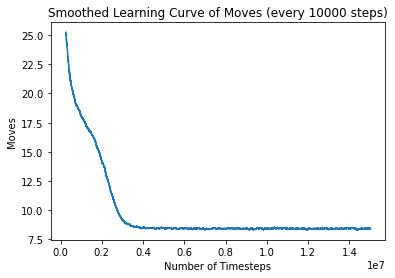

In [23]:
plot_results(log_dir, 10000)

In [49]:
# comme en haut mais avec un modèle différent

ships = {}
ships['bateau'] = 3

grid_size = 6
num_timesteps = 10000000 

best_mean_reward, n_steps, step_interval, episode_interval = -np.inf, 0, 10000, 10000
env = BattleshipEnv(enemy_board=None, ship_locs={}, grid_size=grid_size, ships=ships)

log_dir = "./gym/"
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, filename=log_dir, allow_early_resets=True)

GrosZbi = DQN('MlpPolicy', env, verbose=0)
GrosZbi.learn(total_timesteps=15000)
#model

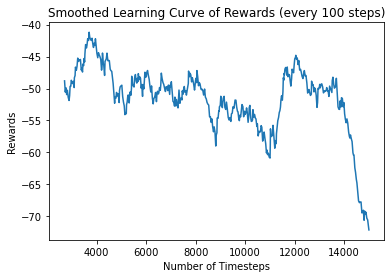

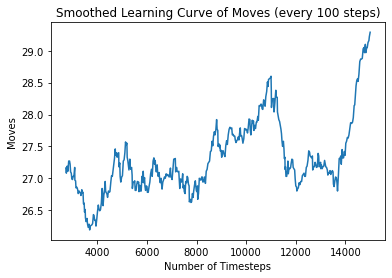

In [51]:
plot_results(log_dir, 100)